<a href="https://colab.research.google.com/github/wlsisl/ESAA_/blob/main/%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D7%2C10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7. 문서 군집화 소개와 실습 (Opinion Review 데이터 세트)

### 문서 군집화 개념 
문서 군집화 : 비슷한 텍스트 구성의 문서를 군집화하는 것이다. 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류할 수 있으므로 앞에서 소개한 텍스트 분류 기반의문서 분류와 유사하다.  

* 문서 군집하는 학습 데이터 세트가 필요없느 ㄴ비지도 학습 기반으로 동작한다.

### Opinion Review 데이터 세트를 이용한 문서 군집화화수행


In [1]:
import pandas as pd
import glob, os
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from google.colab import drive
drive.mount("/content/drive")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


In [ ]:
path=r'/content/drive/MyDrive/topics'
all_files=glob.glob(os.path.join(path, '*.data'))
filename_list=[]
opinion_text=[]

In [ ]:

#개별 파일의 파일명은 filename_list로 취합,
#개별 파일의 파일 내용은 df 로딩 후 다시 string으로 변환해 opinion_text list로 취합합
for file_ in all_files:
  #개별 파일을 읽어서 df로 생성성
  df=pd.read_table(file_, index_col=None, header=0, encoding='latin1')

  #절대 경로로 주어진 파일명을 가공.
  #맨 마지막 .data 확장자도 제거거
  filename_=file_.split('\\')[-1]
  filename=filename_.split('.')[0]

  #파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가가
  filename_list.append(filename)
  opinion_text.append(df.to_string())

#파일명 list와 파일 내용 list 객체를 df로 생성성
document_df=pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,/content/drive/MyDrive/topics/accuracy_garmin_...,...
1,/content/drive/MyDrive/topics/bathroom_bestwes...,...
2,/content/drive/MyDrive/topics/eyesight-issues_...,...
3,/content/drive/MyDrive/topics/buttons_amazon_k...,...
4,/content/drive/MyDrive/topics/features_windows7,...


각 파일 이름 자체만으로 의견의 텍스트가 어떠한 제품/ 서비스에 대한 리뷰인지 알 수 있다. 

문서를 TF-IDF 형태로 피처 벡터화해보자.

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect=TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
#opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect=tfidf_vect.fit_transform(document_df['opinion_text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


문서별 텍스트가 TF-IDF 변환된 피처 벡터화 행렬 데이터에 대해서 군집화를 수행해 어떤 문서끼리 군집되는지 확인. 

군집화 기법 : K-평균
먼저 5개의 중심 기반으로 어떻게 군집화되는지 확인해보자.

In [ ]:
from sklearn.cluster import KMeans

#5개 집합으로 군집화 수행
km_cluster=KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


각 데이터별로 할당된 군집의 레이블을 파일명과 파일 내용을 가지고 있는 데이터프레임에 칼럼 추가해 생성하자.

In [ ]:
document_df['cluster_label']=cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,/content/drive/MyDrive/topics/accuracy_garmin_...,...,4
1,/content/drive/MyDrive/topics/bathroom_bestwes...,...,1
2,/content/drive/MyDrive/topics/eyesight-issues_...,...,0
3,/content/drive/MyDrive/topics/buttons_amazon_k...,...,0
4,/content/drive/MyDrive/topics/features_windows7,...,2


In [ ]:
#cluster_label=0인 데이터는 호텔에 대한 리뷰로 군집화
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
3,/content/drive/MyDrive/topics/buttons_amazon_k...,...,0
2,/content/drive/MyDrive/topics/eyesight-issues_...,...,0
7,/content/drive/MyDrive/topics/fonts_amazon_kindle,...,0
19,/content/drive/MyDrive/topics/navigation_amazo...,...,0
36,/content/drive/MyDrive/topics/price_amazon_kindle,...,0


In [ ]:
#cluster_label=1인 데이터는 킨들, 아이팟, 넷북 등 포터블 전자기기에 대한 리뷰
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
1,/content/drive/MyDrive/topics/bathroom_bestwes...,...,1
11,/content/drive/MyDrive/topics/food_holiday_inn...,...,1
16,/content/drive/MyDrive/topics/food_swissotel_c...,...,1
20,/content/drive/MyDrive/topics/free_bestwestern...,...,1
24,/content/drive/MyDrive/topics/location_bestwes...,...,1
15,/content/drive/MyDrive/topics/location_holiday...,...,1
23,/content/drive/MyDrive/topics/parking_bestwest...,...,1
28,/content/drive/MyDrive/topics/price_holiday_in...,...,1
33,/content/drive/MyDrive/topics/room_holiday_inn...,...,1
38,/content/drive/MyDrive/topics/rooms_bestwester...,...,1


In [ ]:
#cluster_label=2인 데이터은 1과 비슷하지만 주로 차량용 네이게이션으로 군집
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
9,/content/drive/MyDrive/topics/battery-life_ama...,...,2
5,/content/drive/MyDrive/topics/battery-life_ipo...,...,2
6,/content/drive/MyDrive/topics/battery-life_net...,...,2
4,/content/drive/MyDrive/topics/features_windows7,...,2
17,/content/drive/MyDrive/topics/keyboard_netbook...,...,2
25,/content/drive/MyDrive/topics/performance_netb...,...,2
35,/content/drive/MyDrive/topics/screen_garmin_nu...,...,2
29,/content/drive/MyDrive/topics/screen_ipod_nano...,...,2
34,/content/drive/MyDrive/topics/screen_netbook_1...,...,2
40,/content/drive/MyDrive/topics/size_asus_netboo...,...,2


In [ ]:
#cluster_label=3인 데이터은 0과 같이 호텔에 대한 리뷰로 군집화화
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
8,/content/drive/MyDrive/topics/comfort_honda_ac...,...,3
13,/content/drive/MyDrive/topics/comfort_toyota_c...,...,3
22,/content/drive/MyDrive/topics/gas_mileage_toyo...,...,3
26,/content/drive/MyDrive/topics/interior_honda_a...,...,3
21,/content/drive/MyDrive/topics/interior_toyota_...,...,3
14,/content/drive/MyDrive/topics/mileage_honda_ac...,...,3
18,/content/drive/MyDrive/topics/performance_hond...,...,3
37,/content/drive/MyDrive/topics/quality_toyota_c...,...,3
31,/content/drive/MyDrive/topics/seats_honda_acco...,...,3


In [ ]:
#cluster_label=4인 데이터는 토요타와 혼다등 자동차에 대한 리뷰뷰
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,/content/drive/MyDrive/topics/accuracy_garmin_...,...,4
12,/content/drive/MyDrive/topics/directions_garmi...,...,4
10,/content/drive/MyDrive/topics/display_garmin_n...,...,4
30,/content/drive/MyDrive/topics/satellite_garmin...,...,4
44,/content/drive/MyDrive/topics/speed_garmin_nuv...,...,4
43,/content/drive/MyDrive/topics/speed_windows7,...,4
41,/content/drive/MyDrive/topics/transmission_toy...,...,4
45,/content/drive/MyDrive/topics/updates_garmin_n...,...,4


5개로 설정하니 되게 세분화 되어버림. 중심 개수를 3개로 낮춰서 군집화를 해보자.

In [ ]:
from sklearn.cluster import KMeans

#3개의 집합으로 군집화
km_cluster=KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label=km_cluster.labels_
cluster_centers=km_cluster.cluster_centers_

#소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label']=cluster_label
document_df.sort_values(by='cluster_label')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,filename,opinion_text,cluster_label
50,/content/drive/MyDrive/topics/voice_garmin_nuv...,...,0
21,/content/drive/MyDrive/topics/interior_toyota_...,...,0
22,/content/drive/MyDrive/topics/gas_mileage_toyo...,...,0
14,/content/drive/MyDrive/topics/mileage_honda_ac...,...,0
13,/content/drive/MyDrive/topics/comfort_toyota_c...,...,0
41,/content/drive/MyDrive/topics/transmission_toy...,...,0
8,/content/drive/MyDrive/topics/comfort_honda_ac...,...,0
42,/content/drive/MyDrive/topics/sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
26,/content/drive/MyDrive/topics/interior_honda_a...,...,0
37,/content/drive/MyDrive/topics/quality_toyota_c...,...,0


0은 포터블 전자기기 리뷰, 1은 호텔 리뷰, 2는 자동차 리뷰로 군집 구성됨.

### 군집별 핵심 단어 추출하기 

각 군집에 속한 문서는 핵심 단어를 주축으로 군집화돼 있을 것이다. 

* clusters_enters_ : KMeans 객체는 각 군집을 구성하는 단어 피처가 군집의 중심을 기준으로 얼마나 가깝게 위치해 있는지 나타냄
  - 행은 개별 군집, 열은 개별 피처를 의미한다.
  - 배열값으로 제공된다.
  - 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값이다. 
  - ex) cluster_centers[0,1]은 0번 군집에서 두 번째 피처의 위치값이다.


In [ ]:
cluster_centers=km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.00067703 0.00071193 0.         ... 0.         0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.01102405 0.         0.         ... 0.00802599 0.         0.        ]]


(3,2409) 배열인데, 이는 군집이 3개, word피처가 2409개로 구성되었음을 의미한다.

2409개의 피처가 개별 중심과 얼마나 가까운가를 상대 값으로 나타낸 것이다. 1에 가까울수록 중심과 가까운 값을 의미한다.

이제 해당 속성값을 이용해 각 군집별 핵심 단어를 찾아보자. 

* argsort()[:,::-1] : 배열 내 값이 큰 순으로 정렬된 위치 인덱스 값을 반환.

인덱스 값이 필요한 이유: 핵심 단어 피처의 이름을 출력하기 위해서

**<위를 처리할 함수 생성>**

In [ ]:
#군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명을 반환함.
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
  cluster_details={}

  #cluster_centers array 값이 큰 순으로 정렬된 인덱스 값을 반환
  #군집 중심점 별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함
  centroid_feature_ordered_ind=cluster_model.cluster_centers_.argsort()[:, ::-1]

  #개별 군집별로 반복하며 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
  for cluster_num in range(clusters_num):
    #개별 군집별 정보를 담을 데이터 초기화
    cluster_details[cluster_num]={}
    cluster_details[cluster_num]['cluster']=cluster_num

    #cluster_centers_.argsort()로 구한 인덱스를 이용해 top n 피처 단어를 구함
    top_feature_indexes=centroid_feature_ordered_ind[cluster_num, :top_n_features]
    top_features=[feature_names[ind] for ind in top_feature_indexes]

    #top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함.
    top_feature_values=cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

    #cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
    cluster_details[cluster_num]['top_features']=top_features
    cluster_details[cluster_num]['top_features_value']=top_feature_values
    filenames=cluster_data[cluster_data['cluster_label']==cluster_num]['filename']
    filenames=filenames.values.tolist()

    cluster_details[cluster_num]['filenames']=filenames

  return cluster_details


In [ ]:
#보기 좋게 표현하기 위한 함수수

def print_cluster_details(cluster_details):
  for cluster_num, cluster_detail in cluster_details.items():
    print('##### Cluster {0}'.format(cluster_num))
    print('Top features:', cluster_detail['top_features'])
    print('reviews 파일명:', cluster_detail['filenames'][:7])
    print('==============================================')

In [ ]:
#함수 호출
feature_names=tfidf_vect.get_feature_names_out() #IF-IDF 변환된 tfidf_vect객체에서 추출.

cluster_details=get_cluster_details(cluster_model=km_cluster, cluster_data=document_df, feature_names=feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

##### Cluster 0
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'quality', 'gas', 'gas mileage', 'transmission', 'car', 'performance']
reviews 파일명: ['/content/drive/MyDrive/topics/comfort_honda_accord_2008', '/content/drive/MyDrive/topics/comfort_toyota_camry_2007', '/content/drive/MyDrive/topics/mileage_honda_accord_2008', '/content/drive/MyDrive/topics/performance_honda_accord_2008', '/content/drive/MyDrive/topics/interior_toyota_camry_2007', '/content/drive/MyDrive/topics/gas_mileage_toyota_camry_2007', '/content/drive/MyDrive/topics/interior_honda_accord_2008']
##### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
reviews 파일명: ['/content/drive/MyDrive/topics/bathroom_bestwestern_hotel_sfo', '/content/drive/MyDrive/topics/food_holiday_inn_london', '/content/drive/MyDrive/topics/location_holiday_inn_london', '/content/drive/MyDrive/topics/food_swissotel_chicago', '/content/drive/MyDrive/topics/fre

군집화 0은 화면과 배터리 수명 등이 핵심 단어

군집화 1는 방과 서비스 등이 핵심 단어

군집화 2는 실내 인테리어, 좌석, 연료 효율 등이 핵심 단어



---

## 10 텍스트 분석 실습 - 캐글 Mercary Price Suggestion Challenge

일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제다. 
제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성.



---
price : 타겟변수. 

회귀 피처를 학습한 뒤 price를 예측하는 문제이다. 

기존 회귀와 다른점은 item_Description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점이다.

### 데이터 전처리

In [3]:
import os
os.chdir("/content/drive/MyDrive/ESAA_data/")

In [4]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from pyunpack import Archive
Archive('train.tsv.7z').extractall('/content/drive/MyDrive/ESAA_data')

In [7]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df=pd.read_csv('/content/drive/MyDrive/ESAA_data/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [8]:
#null확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


null데이터는 이후에 적절한 문자열로 치환해준다.

target값인 price 칼럼의 데이터 분포도를 살펴보자.
 왜곡돼 있을 경우 로그를를 씌워서 변환하면 정규 분포 형태를 갖게 된다.

<ipython-input-9-d1032245e053>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

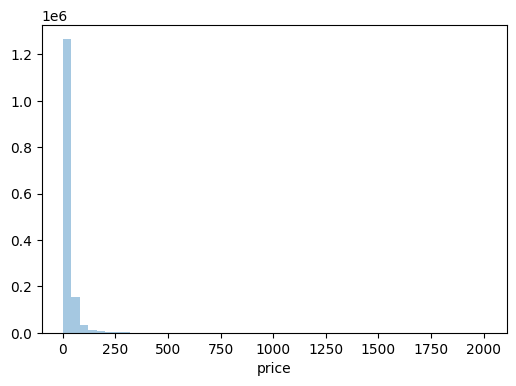

In [9]:
#target값 price 칼럼 분포도 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

매우 왜곡 -> 로그 값으로 변환환

<ipython-input-10-2686a97a1d55>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

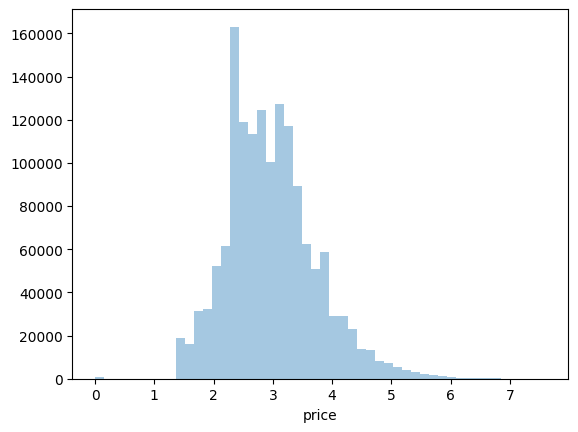

In [10]:
#변환하고 다시 살펴보기기
import numpy as np

y_train_df=np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

정규분포를 따른다. price칼럼을 원래 값에서 로그로 변환된 값으로 변경한다.

In [11]:
#다른 피처 값도 살펴보기
mercari_df['price']=np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

* shipping칼럼은 배송비 유무이며, 값이 비교적 균일하다. 

* Item_condition_id는 판매자가 제공하는 제품 상태로서 각 값이 의미하는 바는 캐글에 기재돼 있지 않아서 알 수 없지만, 1,2,3값이 주를 이루고 있다.
* item_description칼럼은 null값은 별로 없지만 설명이 없는 경우 no라고 되어있다.

In [12]:
#no description 갯수 보기
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()
     

82489

null과 마찬가지 이므로 속상값으로 사용될 수 없다. 적절한 값으로 변경해야한다.


- category_name

'/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다. 가령 대분류, 중분류, 소분류로 나눌 수 있다. 이것은 텍스트이므로 피처 추출 시 tokenizer를'/'로 하여 단어를 분리해 벡터화할 수도 있지만 이것을 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시킨다.

split_cat()을 이용하여 대, 중, 소분류를 분리한다.

In [13]:
#apply lambda 에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null'] #대, 중, 소에 모두 other_null 넣기기

#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so']=zip(*mercari_df['category_name'].apply(lambda x:split_cat(x)))

In [14]:
#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].unique())
print('소분류 개수 :', mercari_df['cat_so'].unique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : ['Tops' 'Computers & Tablets' 'Tops & Blouses' 'Home Décor' 'Jewelry'
 'Other' 'Swimwear' 'Apparel' 'Collectibles' 'Makeup' 'Fragrance'
 'Dresses' 'Office supplies' 'Shoes' 'Gear' 'Athletic Apparel'
 'Cell Phones & Accessories' 'Jeans' 'Underwear' 'Skin Care' 'Toys'
 "Women's Handbags" 'Video Games & Consoles' 'Coats & Jackets' 'Pants'
 'Girls (4+)' 'Antique' 'Kitchen & Dining' 'Sweaters' 'Boys 0-24 Mos'
 'Girls 0-24 Mos' 'Maternity' 'Bedding' 'Exercise' 'Trading Cards'
 'Boys (4+)' 'Storage & Organization' 'Fan Shop' 'Girls 2T-5T'
 "Men's Accessories" 'Boys 2T-5T' "Women's Accessori

대분류의 경우 women, beauty, kids 등의 분류가 매우 많다.

나머지 칼럼의 null값은 일괄적으로 other null로 동일하게 변경하자. 

brand_name은 price값 결정에 영향을 줄 것으로 판단되지만 null값이 매우많다. 따라서 null값을 다른 값으로 변경하기 보다 other null로 변경해준다. 

In [15]:
mercari_df['brand_name']=mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name']=mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description']=mercari_df['item_description'].fillna(value='Other_Null')

In [16]:
#각 칼럼별로 null값 건수 확인, 모두 0이 나옴
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화

문자열 칼럼 중 레이블 또는 원핫인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해보자.

* 선형회귀모델, 회귀트리모델 모두 이용한다.

* 선형회귀모델에서는 원핫인코딩을 적용해준다.

* 피처 벡터화의 경우 비교적 짧은 텍스트의 경우는 count기반, 긴 텍스트는 TD-IDF기반 적용



In [17]:
#상품 브랜드명

print('brand name의 유형 건수 :', mercari_df['brand_name'].unique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : ['Other_Null' 'Razer' 'Target' ... 'Astroglide' 'Cumberland Bay'
 'Kids Only']
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


대부분 명료한 문자열로 돼 있다. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용한다. 

In [18]:
#상품명 유형

print('name의 유형 건수 :', mercari_df['name'].unique())
print('name sample 10건 : \n', mercari_df['name'].value_counts()[:10])

name의 유형 건수 : ['MLB Cincinnati Reds T Shirt Size XL' 'Razer BlackWidow Chroma Keyboard'
 'AVA-VIV Blouse' ... '21 day fix containers and eating plan'
 'World markets lanterns' 'Brand new lux de ville wallet']
name sample 10건 : 
 Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64


상품명은 name속성의 경우 종류가 매우 많다. 유형이 매우 많고 적은 단어 위주의 텍스트 형태로 돼 있으므로 count기반으로 피처 벡터화 변환 적용한다.

shipping과 category_name 모두 원핫인코딩을 적용한다.

item_description은 가장 긴 텍스트를 가지고 있다. 

In [19]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

비교적 문자열이 크므로 해당 칼럼은 TF-IDF로 변환한다.

이제 각각 피처벡터화를 해보자.

In [20]:
#name 속성 피처 벡터화 변환
cnt_vec=CountVectorizer()
X_name=cnt_vec.fit_transform(mercari_df.name)

#item_description 피처 벡터화 변환
tfidf_descp=TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp=tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)
     

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


.fit_transform로 반환하는 데이터는 희소행렬 형태이다.

희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야하고, 앞으로 인코딩 될 모든 변수들도 이 둘과 결합돼 ML모델을 실행하는 기반 데이터 세트로 재구성돼야한다.

-> 인코딩 대상 칼ㄹ럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩

* LabelBinarizer : 희소 행렬 형태의 원핫인코딩 지원
* hstack() : 희소행렬 결합할 때 사용

In [21]:
#인코딩
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name=LabelBinarizer(sparse_output=True)
X_brand=lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id=LabelBinarizer(sparse_output=True)
X_item_cond_id=lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping=LabelBinarizer(sparse_output=True)
X_shipping=lb_shipping.fit_transform(mercari_df['shipping'])

#cat_dae 등 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae=LabelBinarizer(sparse_output=True)
X_cat_dae=lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung=LabelBinarizer(sparse_output=True)
X_cat_jung=lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so=LabelBinarizer(sparse_output=True)
X_cat_so=lb_cat_so.fit_transform(mercari_df['cat_so'])

In [22]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 컬럼이 매우 만힝 생겼지만 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제가 없다. 

In [23]:
#결합

from scipy.sparse import hstack
import gc

sparse_matrix_list=(X_name, X_descp, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


이제 이렇게 만들어진 데이터 세트에 회귀를 적용해 price값을 예측할 수 있도록 모델을 만들 차례이다.

## 릿지 회귀 모델 구축 및 평가

여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것이므로 로직을 함수화 해야한다.

* 평가로직 함수화

RMSLE를 사용한다. 주의할 점은 로그 변환을 취했기 때문에 예측도 로그 변환한 값 수준이다. 따라서 학습 모델을 이용한 예측된 PRICE값은 다시 로그의 역변환인 지수 변환을 수행해 복원한다.

In [24]:
def rmsle(y, y_pred):
  #underflow, overflow를 막기 위해 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred),2)))

def evaluate_org_price(y_test, preds):
  #원본 데이터는 log1p 변환되었으므로 expm1으로 원복 필요.
  preds_exmpm=np.expm1(preds)
  y_test_exmpm=np.expm1(y_test)

  #rmsle로 RMSLE 값 추출
  rmsle_result=rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

학습용 데이터를 생성하고 모델을 학습/예측하는 로직을 별도의 함수로 만들자. 

In [25]:
#최종 데이터 세트로 결합할 희소 행렬 리스트를 가진다.
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  #scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X=hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  #모델 학습 및 예측
  model.fit(X_train, y_train)
  preds=model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

### 릿지 예측 수행

개별 함수를 만들었으면 이제 이를 이용해 먼저 릿지로 회귀 예측을 수행해보자. 

수행 전에 Merari상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보자.

In [26]:
linear_model=Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list=(X_name, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test=model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('item description을 제외했을 때 rmsle 값 ;', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list=(X_descp, X_name, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test=model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('item description을 포함함했을 때 rmsle 값 ;', evaluate_org_price(y_test, linear_preds))

item description을 제외했을 때 rmsle 값 ; 0.4983990938999374
item description을 포함함했을 때 rmsle 값 ; 0.4680329023962086


rmsle값이 많이 감소했다. item_Description영향이 중요하다.

## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

다음으로는 LightGBM을 이용해 회귀를 수행하고, 위에서 구한 릿지 모델 예측값과 이번에 구할 예측값을 간단한 앙상블 방식으로 섞어 평가하자.

* lightGBM 회귀 수행행

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list=(X_descp, X_name, X_brand, X_item_cond_id,
                    X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model=LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test=model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('lgbm rmsle 값 ;', evaluate_org_price(y_test, lgbm_preds))

In [ ]:
preds=lgbm_preds*0.45+linear_preds*0.55
print('lgbm과 ridge를 앙상블 한 최종 rmsle 값 :', evaluate_org_price(y_test, preds))

예측 성능이 나아졌다다. 

이제 앙상블해서 최종 예측 결과값을을 평가해보자.

성능이 개선되었다다.


---
## 11. 정리

텍스트 분석을 위한 기반 프로세스를 알아보았다. 
텍스트 분류, 감성분석, 토픽 모델링, 텍스트 군집화 및 유사도 측정 등을 직접 파이썬 코드를 이용해 구현했다.

**<머신러닝 기반 텍스트 분석 프로세스>**

1. 텍스트 사전 정제 작업 등 텍스트 정규화 작업 수행
2. 이들 단어들을 피처 벡터화로 변환
3. 생성된 피처 벡터 데이터 세트에 머신러닝 모델 학습, 예측, 평가

* 정규화 작업 
  - 텍스트 클렌징, 대소문자 변경, 단어 토큰화 , 의미 없느 ㄴ단어 필터링, 어근 추출

* 피처 벡터화
  - BOW의 대표 방식인 count기반과 TF-IDF 기반 피처 벡터화 

-> 희소행렬 데이터세트이다.

머신러닝은 이러한 희소 행렬 기반에서 최적화되어야 한다.

**<텍스트 분류절>**

문서들을 피처 벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 분류해 보았다. 

<감성 분석절>
**굵은 텍스트**
지도학습 기반으로 긍정/부정 이진 분류를 적용한 방식과 감성사전을 이용한 방식 두가지를 살펴봄

**<토픽 모델링>**

lda를 이용해 뉴스그룹 내의 많은 문서들이 공통적으로 가지는 토픽들을 추출

**<텍스트 군집화>**

K-평균군집화 기법을 이용해 비슷한 문서들끼리 군집화했음.

또한 한글 형태소 분석기인 KoNLPy패키지를 이용해 네이버에서 제공하는 한글로 된 영화리뷰에 이진진 분류를 적용해보았다.
